# Cambiamenti climatici

## Requisiti:

In [142]:
# !pip install pandas
# !pip install tabulate
# !pip install matplotlib 
# !pip install plotly

## 1. Data collection
I dati usati in questa applicazione si trovano nella cartella [data](applicazione/data/). 
<ul>
    <li>In original si trovano i file originali trovati su internet</li>
    <li>In modified si trovano i file "processati"</li>
</ul>

## Dati sulle temperature e sulle stazioni geografiche
I file contenenti i dati relativi alle temperature ([temperatures.dat](applicazione/data/original/temperatures.dat)) e alle stazioni geografiche ([stations.inv](applicazione/data/original/stations.inv)) sono stati trovati sul sito [National Centers for Environmental Information](https://www.ncei.noaa.gov/). Sono scaricabili al seguente link: https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcf.tar.gz <br>


## Dati sui Paesi
I file contenenti informazioni sui Paesi sono stati trovati su due repository di github: <br>
- [fips_to_iso_country_codes.csv](applicazione/data/original/fips_to_iso_country_codes.csv) trovato al seguente link: https://github.com/mysociety/gaze/blob/master/data/fips-10-4-to-iso-country-codes.csv <br>
- [countries_info.csv](applicazione/data/original/countries_info.csv) trovato al seguente link https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv <br>

## 2. Data processing

In [2]:
import pandas as pd
import os

pd.set_option('display.max_rows', 10)

DATA_FOLDER = "applicazione" + os.path.sep + "data" + os.path.sep
DATA_ORIGINAL_FOLDER = DATA_FOLDER + "original"+ os.path.sep
DATA_MODIFIED_FOLDER = DATA_FOLDER + "modified"+ os.path.sep

### Stazioni e temperature
I file [stations.inv](applicazione/data/original/stations.inv) e [temperatures.dat](applicazione/data/original/temperatures.dat) trovati su internet sono Fixed Width Text File. Ho deciso di modificarli e convertirli in file CSV ([stations_created.csv](applicazione/data/modified/stations_created.csv), [tempetatures_created.csv](applicazione/data/modified/tempetatures_created.csv)). In questo modo creo due file CSV con i dati già "puliti" e pronti per essere letti. Inoltre, la funzione read_csv per leggere file CSV è molto più veloce di read_fwf per leggere file Fixed Width, quindi <mark> continua... </mark>
<br>

#### Stazioni
Il file [stations_created.csv](applicazione/data/modified/stations_created.csv) ha la seguente struttura:
|Campo| Significato|
|:-|:-|
|station_id| Codice identificativo della stazione. I primi due caratteri sono il codice FIPS del Paese|
|latitude| Latitudine della stazione in gradi decimali|
|longitude| Longitudine della stazione in gradi decimali|
|station_elev| Altitudine della stazione in metri; <mark> FORSE NON E' COSI' il valore -999.0 indica un dato mancante|
|station_name| Nome della stazione|
|fips| Codice FIPS del Paese|

Ho creato uno script per creare il file:

In [3]:
import calendar

# File con le stazioni
FILE_ORIGINALE_STATIONS = DATA_ORIGINAL_FOLDER + "stations.inv"
FILE_CSV_STATIONS = DATA_MODIFIED_FOLDER + "stations_created.csv"
HEADERS_STATIONS = ["station_id","latitude","longitude","station_elev","station_name"]

if not os.path.exists(FILE_CSV_STATIONS):
    print("Creo file csv partendo da",FILE_ORIGINALE_STATIONS,"...")
    
    # Leggo il file
    df = pd.read_fwf(FILE_ORIGINALE_STATIONS,widths=[11,9,10,7,31], header=None, names=HEADERS_STATIONS)
    
    # Aggiungo il campo fips
    df['fips'] = df["station_id"].apply(lambda x : x[0:2])
    HEADERS_STATIONS += ["fips"]
    
    # Trasformo i valori -999.0 di station_elev in Nan
    df["station_elev"] = df["station_elev"].apply(lambda x: pd.NA if x == 9999 else x)

    # Converto in formato CSV
    df.to_csv(FILE_CSV_STATIONS, index=False)
print("File creato correttamente!")

File creato correttamente!


#### tempetatures_created.csv
Il file [tempetatures_created.csv](applicazione/data/modified/stations_created.csv) ha la seguente struttura:
|Campo| Significato|
|:-|:-|
|station_id| Codice identificativo della stazione. I primi due caratteri sono il codice FIPS del Paese|
|year| Anno in cui sono state misurate le temperature|
|month_value| Valore della temperatura del mese "month". I valori della temperatura sono in centesimi di grado Celsius, ma sono espressi come numeri interi (ad es. dividere per 100,0 per ottenere gradi Celsius interi). <br>Il valore -9999 indica un dato mancante. |
|<mark>TOLTO month_dm_flag| data measurement flag (indicatore della misurazione dei dati). <br>Se è vuoto -> nessuna informazione di misurazione applicabile <br> Se è una lettera tra a-i -> numero di giorni mancanti nel calcolo della temperatura media mensile |
|<mark>CAMBIATO month_qc_flag| quality control flag del mese "month". <br> Se è vuoto, non c'è stato nessun fallimento del controllo di qualità oppure il valore non può essere valutato. <br> Per gli altri valori, consultare la [documentazione dei dataset]((https://www.ncei.noaa.gov/pub/data/ghcn/v4/readme.txt)) |
|<mark>TOLTO month_ds_flag| Indica l'origine dati per il valore del mese "month". Per avere altre informazioni, consultare la [documentazione di tale campo](https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm-flags.txt)|

Ho creato uno script per creare il file:


In [4]:
# File con le temperature
FILE_ORIGINALE_TEMPERATURES = DATA_ORIGINAL_FOLDER + "temperatures.dat"
FILE_CSV_TEMPERATURES = DATA_MODIFIED_FOLDER + "temperatures_created.csv"

# Creo due liste: una con le lunghezze dei campi e una con i nomi delle colonne
list_width= [11,4,4] + [j for i in [[5,1,1,1] for _ in range(12)] for j in i] 
# print(list_width)
HEADERS_TEMPERATURES = ["station_id", "year", "DEL_ME"]
for i in range(1,13):
    month_name = calendar.month_name[i]
    HEADERS_TEMPERATURES += [month_name+"_value","DEL_ME"+str(i)+"a",month_name+"_qc_flag","DEL_ME"+str(i)+"b"]

if not os.path.exists(FILE_CSV_TEMPERATURES):
    print("Creo file csv partendo da",FILE_ORIGINALE_TEMPERATURES,"...")
    
    # Leggo il file
    df = pd.read_fwf(FILE_ORIGINALE_TEMPERATURES, widths=list_width,header=None, names=HEADERS_TEMPERATURES)
    
    # Elimino le colonne non necessarie
    HEADERS_TEMPERATURES = [i for i in HEADERS_TEMPERATURES if not i.__contains__("DEL_ME")]
    df = df[HEADERS_TEMPERATURES]

    # Cambio i valori valori "vuoti" di month_qc_flag con un trattino. Questi valori vuoti, indicano che 
    # non ci sono stati problemi durante la rilevazione dei dati, non indicano dati mancanti.
    # Cambio i valori -9999 di month_value con NaN. Trasformo anche i valori validi in gradi decimali. 
    for i in range(1,13):
        month_name = calendar.month_name[i]
        df[month_name+"_qc_flag"] = df[month_name+"_qc_flag"].apply(lambda x: "-" if pd.isna(x) else x)
        df[month_name+"_value"] = df[month_name+"_value"].apply(lambda x: pd.NA if str(x) == "-9999" else x/100)

    # Rimuovo i record con valori nulli
    #df.dropna()
    
    # Converto in formato CSV
    df.to_csv(FILE_CSV_TEMPERATURES, index=False)

print("File creato correttamente!")

File creato correttamente!


### Paesi
Per quanto riguarda le informazioni sui paesi, ho unito i due file [country_info.csv](applicazione/data/original/countries_info.csv) e [fips_to_iso_country_codes.csv](applicazione/data/original/fips_to_iso_country_codes.csv) in un unico file [countries_created.csv](applicazione/data/original/countries_created.csv) con la seguente struttura:

|Campo|Significato|
|:-|:-|
|fips| Codice FIPS del paese|
|name_country| Nome del Paese|
|region| Continente di appartenenza|
|sub-region| Zona del continente (nord, sud, est, ovest)|
|region-code| Codice di region|
|sub-region-code| Codice di sub-region|

Ho creato uno script per creare il file:

In [5]:
# File dei paesi
FILE_ORIGINALE_FIPS_TO_ISO = DATA_ORIGINAL_FOLDER + "fips_to_iso_country_codes.csv"
FILE_ORIGINALE_COUNTRY_INFO = DATA_ORIGINAL_FOLDER + "countries_info.csv"
FILE_CSV_COUNTRIES_CREATED = DATA_MODIFIED_FOLDER + "countries_created.csv"

if not os.path.exists(FILE_CSV_COUNTRIES_CREATED):
    print("Creo file csv partendo da",FILE_ORIGINALE_FIPS_TO_ISO, "e", FILE_ORIGINALE_COUNTRY_INFO,"...")

    # Leggo i files originali
    df_fips = pd.read_csv(FILE_ORIGINALE_FIPS_TO_ISO)
    df_country = pd.read_csv(FILE_ORIGINALE_COUNTRY_INFO)

    # Faccio il join sul codice alpha-2
    merged = pd.merge(df_fips, df_country, how='left',left_on='ISO 3166', right_on='alpha-2')

    # Elimino le colonne non necessarie e rinomino le altre
    merged = merged.drop(['ISO 3166','iso_3166-2', 'alpha-3', 'alpha-2', 'country-code', 'intermediate-region', 'intermediate-region-code'], axis=1)
    merged['name_country'] = merged.apply(lambda x : str(x['Name'] if pd.isna(x["name"]) else x['name']), axis=1)
    merged = merged.drop([ 'name', 'Name'], axis=1)
    merged = merged.rename(columns={"FIPS 10-4":"fips"})

    # e creo un nuovo file
    merged.to_csv(FILE_CSV_COUNTRIES_CREATED, index=False, header=True)

print("File creato correttamente!")

File creato correttamente!


## 3. Elaborazione dei dati <mark>(?)

Una volta creati tutti i file CSV, per usarli basterà leggerli e fare il join sul campo 'fips' e 'station_id':

In [152]:
df_temperatures = pd.read_csv(FILE_CSV_TEMPERATURES).dropna()
df_stations = pd.read_csv(FILE_CSV_STATIONS)
df_country = pd.read_csv(FILE_CSV_COUNTRIES_CREATED)

1. Esistono i cambiamenti climatici? 
    - Mostrare mappa del mondo delle temperature medie nel 19**
    - Mostrare mappa delle temperature medie nel 2020 e 2021
    - Mostrare un grafico con i cambiamenti
2. Perché dobbiamo fare qualcosa per fermarli?
    - Mostrare grafico di come saranno le temperature nel 2100 (seguendo il trend)
3. Altra conseguenza: innalzamento dei livelli del mare
4. Quali paesi risentono di piu' dei cambiamenti climatici?
    - Mostrare un grafico a colonne
4. Anni piu' caldo


---
Quando le stazioni hanno iniziato a raccogliere dati? Qual è stata la prima a raccogliere dati?
Quante stazioni per ogni paese?
Quale contienente ha piu' stazioni?
Quale stazione ha raccolto piu' dati?


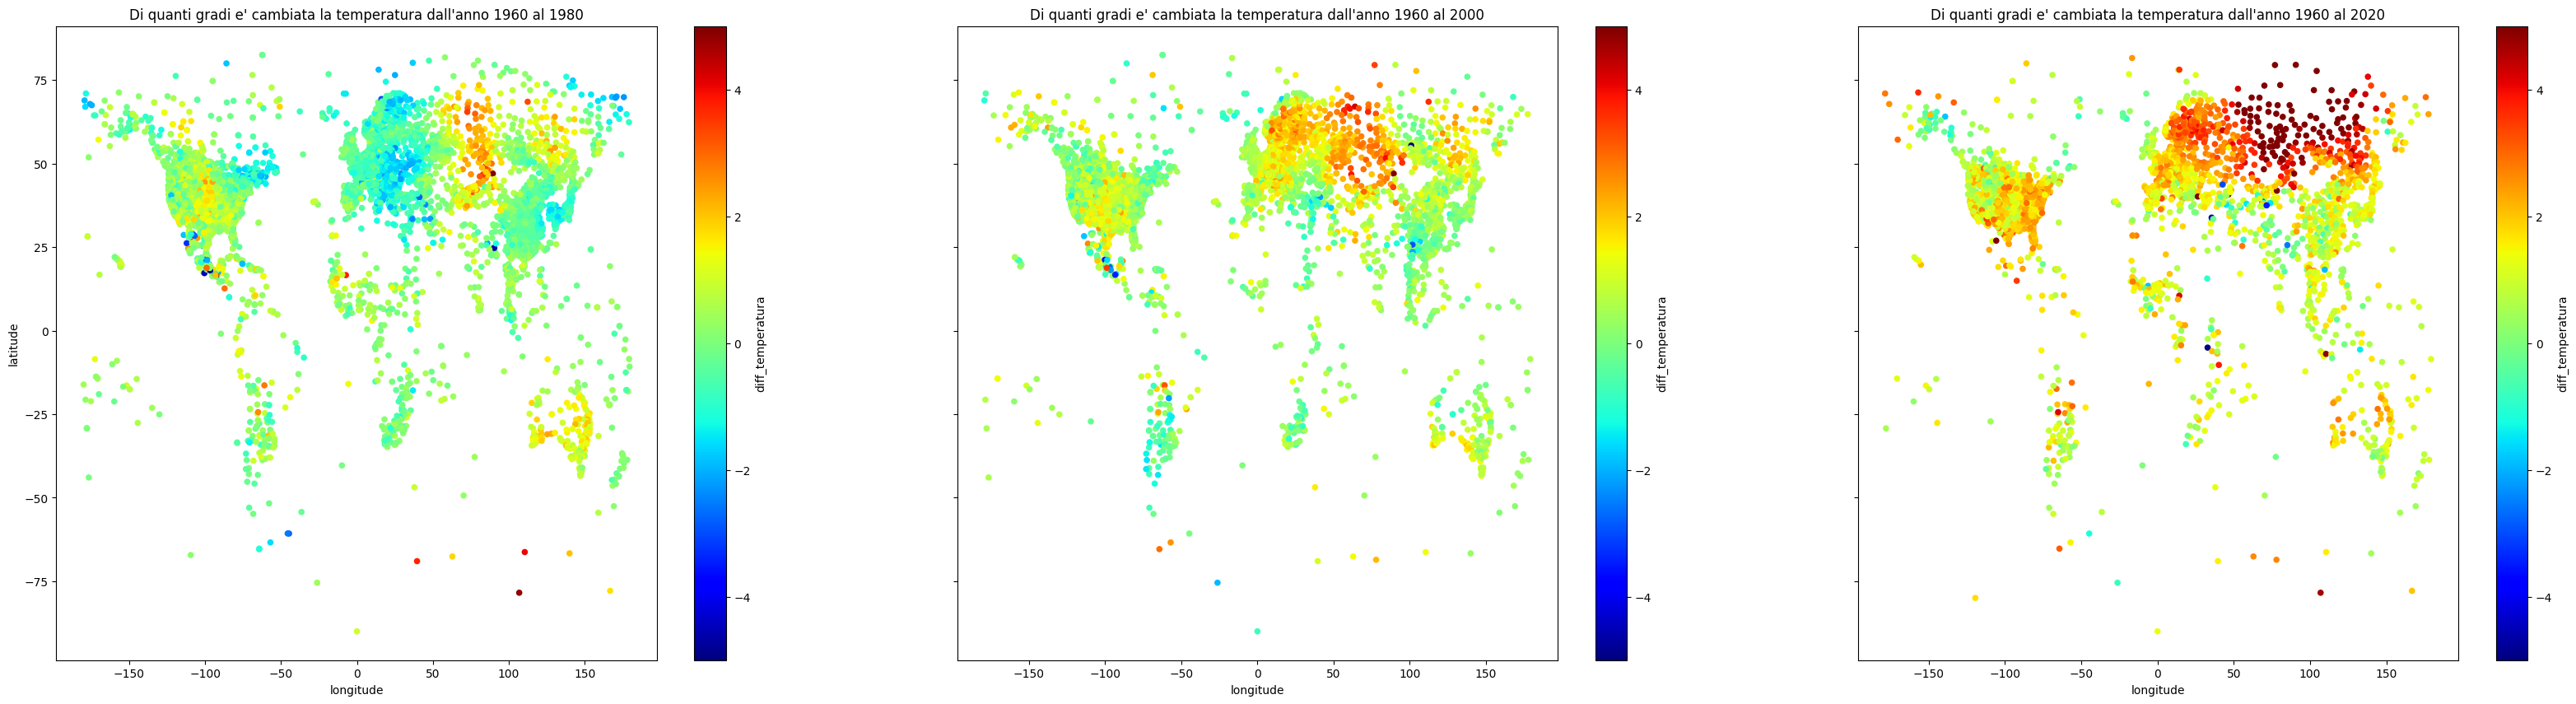

In [215]:
import matplotlib.pyplot as plt

def plot_map_difference_temperatures(list_years):
    """ Funzione che disegna i grafici con le differenze di temperature degli anni dati in input."""
    def plot_map_two_years(year1, year2, i):
        def get_col_name(year):
            return 'temperatura_year_'+str(year)
        
        def get_df(anno):
            """Questa funzione ritorna un DataFrame contenente le rilevazioni delle temperature dell'anno dato in input.
            Il dataframe in output ha i seguenti campi:
                station_id, latitude, longitude -> informazioni della stazione 
                year -> anno in input
                temperatura_year_anno -> temperatura media dell'anno 'anno' in input
            """
            df_to_plot = df_temperatures.merge(df_stations, on="station_id")        # Faccio il merge con le stazioni
            df_to_plot = df_to_plot[(df_to_plot["year"] == anno)]                   # Seleziono solo l'anno desiderato
            df_to_plot[get_col_name(anno)] = df_to_plot[[calendar.month_name[i]+"_value" for i in range(1,13)]].mean(axis=1)    # Calcolo la temperatura media annuale 
            df_to_plot = df_to_plot[["station_id", "year","latitude", "longitude", get_col_name(anno)]]                         # Seleziono solo alcuni campi
            return df_to_plot   
    
        # Faccio il merge dei due dataframe dei due anni in input, in base alla station_id
        df = get_df(year1).merge(get_df(year2), how="inner",  on=["station_id", "latitude", "longitude"])

        # Calcolo la differenza della temperatura media annuale
        df['diff_temperatura'] = df[get_col_name(year2)] - df[get_col_name(year1)]
        
        # Disegno il grafico
        titolo = "Di quanti gradi e' cambiata la temperatura dall'anno "+str(year1)+" al " + str(year2)
        grafico = df.plot(x="longitude", y="latitude", c="diff_temperatura",  clim=(-5,5),kind="scatter",legend=None, colormap="jet", title=titolo, ax=axes[i], figsize=(40,10))#, figsize=(20, 10))

    
    fig, axes = plt.subplots(nrows=1,ncols=len(list_years)-1, sharey=True)
    i=0
    for anno2 in list_years[1:]:
        plot_map_two_years(list_years[0], anno2, i)
        i += 1
    plt.show()

# Disegno le tre mappe
plot_map_difference_temperatures([1960, 1980, 2000, 2020])

In [10]:
# print("len prima =\t", len(df_temperatures))
# for i in range(1,13):
#     df_temperatures = df_temperatures[df_temperatures[calendar.month_name[i]+"_value"] != pd.NA]
# print("len dopo =\t", len(df_temperatures))
# display(df_temperatures)


In [11]:
# import tabulate

# df_merged = df_temperatues.merge(df_stations, on='station_id')
# df_merged = df_merged.merge(df_country, on='fips')
# colonne = ["station_id", "year", "station_name", "latitude", "longitude", "station_elev", "region", "sub-region"] + [str(calendar.month_name[i]+"_value") for i in range(1,13)]

# table = tabulate.tabulate(df_merged[colonne].sample(n=5), headers='keys', tablefmt='html')
# display(table)

## 

In [12]:
# df_temperatues = pd.read_csv(FILE_CSV_TEMPERATURES)

In [13]:
# for i in range(1,13):
#     month_name = calendar.month_name[i]
#     print("********")
#     new_df  = df_temperatues
    
    
#     new_df[month_name+"_qc_flag"] = df_temperatues[month_name+"_qc_flag"].apply(lambda x: "-" if pd.isna(x) else x)
#     prova = new_df[new_df[month_name+"_qc_flag"] == "-"]
#    # lista = list(set(prova.to_list()))
#     print(month_name, len(prova))

    

In [14]:

# # for index, row in merged.iterrows():
# #     print(f"{index:5}", f"{row['name']:50}",row['fips'])


# # print(merged)

# df_stations = pd.read_csv(FILE_CSV_STATIONS)
# # print(len(pd.unique(df_stations['fips'])))
# # 
# merged2 = df_stations.merge(merged, how='left', on='fips')
# # merged2 = merged2.drop(['name_country', 'region', 'sub-region', 'region-code', 'sub-region-code'], axis=1)
# merged2 = merged2.drop_duplicates() 
# merged2 = merged2.reset_index()

# # print(merged2)
# for index, row in merged2.iterrows():
#     print(str(row).replace("\n","\t",-1))

